<a href="https://colab.research.google.com/github/AlfaIV/RFinfSystem/blob/hm1/%D0%94%D0%971_%D0%A0%D0%A1%D0%9F%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 1
Домашнее задание 1 по курсу РСПИ

* вариант: 16
* группа: РЛ1-93
* выполнил: Шаповалов Иван
* [github](https://github.com/AlfaIV/RFinfSystem/tree/hm1)
* [collab](https://colab.research.google.com/drive/1CYvE8E6huC6DDZrXEbwslbk7r5hVKu60?usp=sharing)


### Условие:

1. Напишите согласно вариантам из приложения следующие функции для оценки характеристик схемы компандирования:
* функция компрессора, на вход которой передается нормированный с нулевым математическим ожиданием вещественный сигнал (|s| <= 1) и настроечный параметр для заданной схемы сжатия;
* функция равномерного квантования, на вход которой передается сигнал с выхода компрессора, а на выходе формируются целочисленные отсчеты с заданной разрядностью Ь;
* функция экспандера для заданного закона компрессора и таких же параметрах, формирующая из целочисленных значений сигнала на входе вещественный сигнал с нулевым математическим ожиданием.
1. Изобразите в draw.іо функциональную схему системы компандирования, включающую источник сигнала, функции преобразования и оконечную схему сравнения восстановленного сигнала и исходного. Добавьте ее в отчёт.
1. Сгенерируйте непериодический массив отсчетов входного сигнала (более 10 ООО отсчетов) по форме согласно варианту. Используйте иррациональные числа для нормированных частот повторения заданных последовательностей.
1. Сделайте преобразование над полученным сигналом по схеме из п.2 и вьтчислите отношение С/Ш по формуле (SQNR):
1. Постройке график зависимости SQNR от параметра компрессора и найдите оптимальное значение параметра по критерию максимума SQNR. Изобразите на одном графиках осциллограммы сигналов с и без компандирования при оптимальном и
неоптимальном значении параметра сжатия. Сделайте выводы по полученным результатам.

**Исходные данные**

N  | Схема сжатия | Разрядность АЦП,b | Вид сигнала
---|--------------|-------------------|--------------
16 | A-law        | 5                 | Коррелированный гауссовский случайный процесс с параметрами (0, 1)

Модель коррелированный гауссовский случайный процесс:
$$s(n) = a_1 s(n - 1) + b_0 x(n) + b_1 x(n - 1);$$
где $x(n)$ - гауссовский случайный процесс с параметрами $N(0, 1).$

Подключим требуемые библиотеки.

In [1]:
from math import sqrt, pi, exp, log, copysign, log10
from numpy import linspace, vectorize, random
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sg
import copy

Внесем требуемые константы.

In [2]:
b = 5
A = 87.56
1/A

0.011420740063956145

## Отладка основных компонентов схемы обработки

Прежде чем собрать требуемую схему обработки, произведем отладку её компонентов. Убедимся, что они работают нормально.

### Формирование входного сигнала
Начнем формирование **входнго сигнала**.

Для начала сформируем гауссовский СП с нулевым мат.  ожиданием и стандартным отклонением = 1, используя пакет Numpy.

In [3]:
mean = 0
std = 1
size = int(1e4)
gauss_sig = np.random.normal(mean, std, size)

Получим следующую форму сигнала

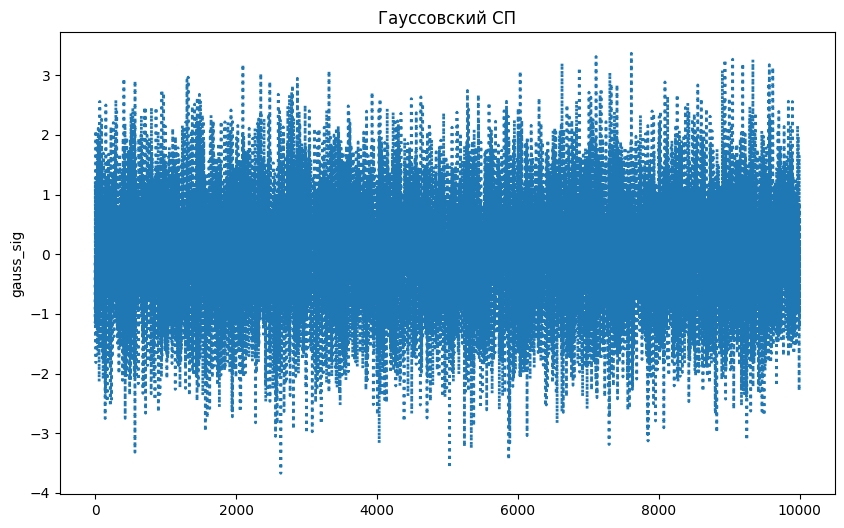

In [4]:
fig, ax = plt.subplots()

plt.plot(gauss_sig,
        linewidth=2.0,
        linestyle=':',)
fig.set_size_inches(10, 6)

plt.title("Гауссовский СП")
plt.xlabel("")
plt.ylabel("gauss_sig")

plt.show()

Теперь на основе полученных выборок сигнала сформируем сигнал требуемого, в условии задания, вида

In [5]:
def s(n, gauss_sig):
  a_1, b_0, b_1 = 0.5, 1, 2 #параметры принимаем такими так как не заданно другое значение
  try:
    previous_val = b_0*gauss_sig[0] #храним предыдущее значение, избавляемся от рекурсии
    returned_sig = [] #возвращаемый массив данных
    for n_i in range(n)[1:]:
      returned_sig.append(previous_val)
      previous_val = a_1*previous_val + b_0*gauss_sig[n_i] + b_1*gauss_sig[n_i - 1]

    returned_sig.append(previous_val)
    return returned_sig
  except IndexError:
    print("Некорректный массив гауссовых значений")

In [6]:
n = np.arange(size)
sig = s(size, gauss_sig)

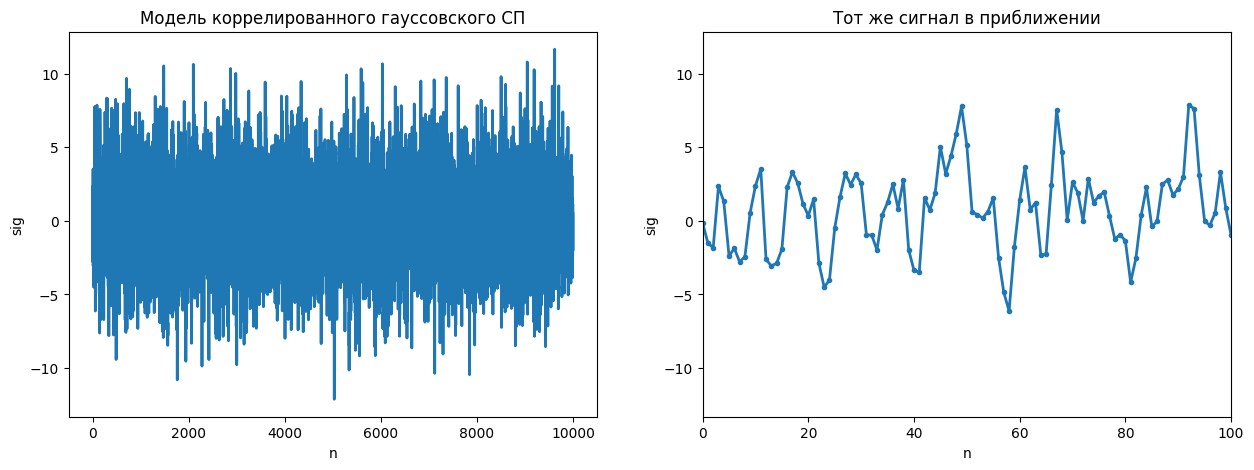

In [7]:
# plot
fig, ax = plt.subplots(1,2)

plt.subplot(1, 2, 1)
plt.plot(n, sig, linewidth=2.0)

plt.title("Модель коррелированного гауссовского СП")
plt.xlabel("n")
plt.ylabel("sig")

plt.subplot(1, 2, 2)
plt.plot(n, sig, linewidth=2.0, marker=".")

plt.title("Тот же сигнал в приближении")
plt.xlabel("n")
plt.ylabel("sig")
plt.xlim(0,1e2)


fig.set_size_inches(15, 5)
plt.show()



Изучим статистические характиристики полученного сигнала.

In [8]:
print("Для ненормированного \"исходного\" сигнала:")
print("Среднее значение:", np.mean(sig))
print("Медиана:", np.median(sig))
print("Дисперсия:", np.var(sig))
print("Стандартное отклонение:", np.std(sig))
print("Минимальное значение:", np.min(sig))
print("Максимальное значение:", np.max(sig))

Для ненормированного "исходного" сигнала:
Среднее значение: 0.13790514251704739
Медиана: 0.15310171242031528
Дисперсия: 9.53971518981093
Стандартное отклонение: 3.088642936600301
Минимальное значение: -12.123005029927455
Максимальное значение: 11.65159629261036


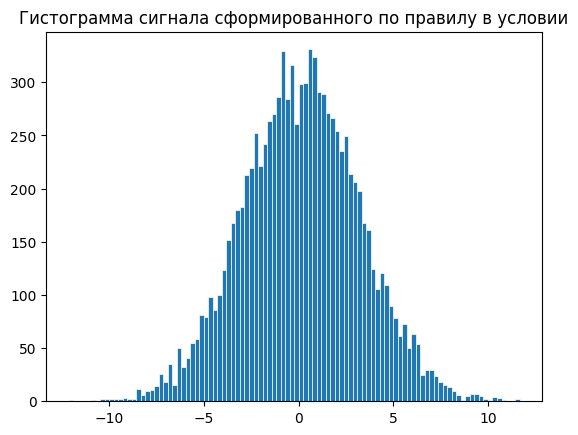

In [9]:
fig, ax = plt.subplots()

ax.hist(sig, bins=int(size/100), linewidth=0.5, edgecolor="white")

plt.title("Гистограмма сигнала сформированного по правилу в условии")
plt.show()

Так как в условии требуеться нормированный сигнал с нулевым мат. ожиданием. Нормируем полученный сигнал

In [10]:

sig_norm_ = (sig - np.mean(sig))/np.std(sig)
sig_norm = 2*(sig_norm_ - min(sig_norm_))/(max(sig_norm_) - min(sig_norm_)) - 1

Теперь мы имеем действительно нормированный сигнал

In [11]:
print("Для нормированного \"исходного\" сигнала:")
print("Среднее значение:", np.mean(sig_norm))
print("Медиана:", np.median(sig_norm))
print("Дисперсия:", np.var(sig_norm))
print("Стандартное отклонение:", np.std(sig_norm))
print("Минимальное значение:", np.min(sig_norm))
print("Максимальное значение:", np.max(sig_norm))
# print("===================")

Для нормированного "исходного" сигнала:
Среднее значение: 0.031429297686806655
Медиана: 0.032707684625633004
Дисперсия: 0.06751012534592123
Стандартное отклонение: 0.25982710664193837
Минимальное значение: -1.0
Максимальное значение: 1.0


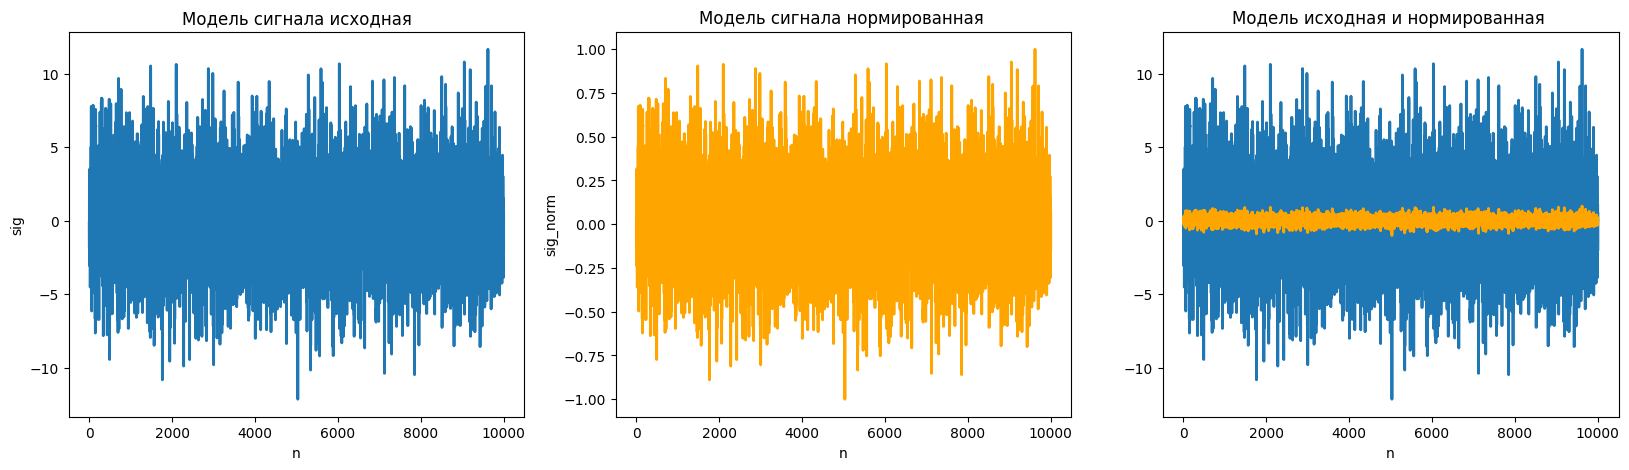

In [12]:
# %%capture
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3)


ax1.plot(n, sig, linewidth=2.0)
ax1.set_title('Модель сигнала исходная')
ax1.set_xlabel('n')
ax1.set_ylabel('sig')

ax2.plot(n, sig_norm, linewidth=2.0, color="orange")
ax2.set_title('Модель сигнала нормированная ')
ax2.set_xlabel('n')
ax2.set_ylabel('sig_norm')

ax3.plot(n, sig, linewidth=2.0)
ax3.plot(n, sig_norm, linewidth=2.0, color="orange")
ax3.set_title('Модель исходная и нормированная ')
ax3.set_xlabel('n')




fig.set_size_inches(20, 5)
plt.show()

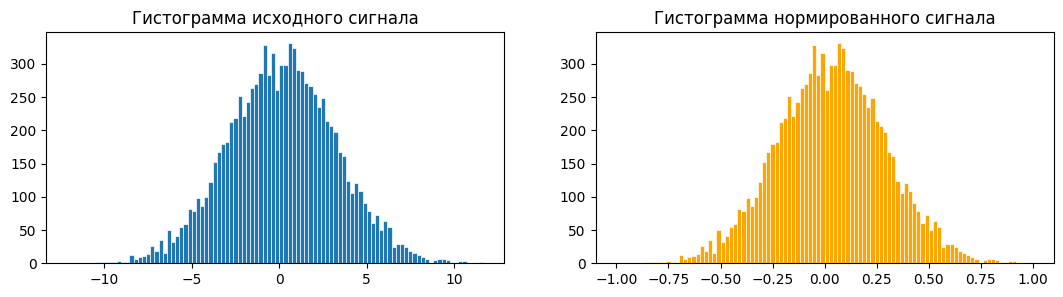

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(sig, bins=int(size/100), linewidth=0.5, edgecolor="white")
ax1.set_title('Гистограмма исходного сигнала')

ax2.hist(sig_norm, bins=int(size/100), linewidth=0.5, edgecolor="white", color="orange")
ax2.set_title('Гистограмма нормированного сигнала')

fig.set_size_inches(13, 3)
plt.show()

### Компрессирование
Теперь проведем **компрессирование** сигнала, по А-закону. По следующей формуле

\begin{equation}
    y = sgn(x)
    \begin{cases}
      \frac{A|x|}{1 + ln(A)}, |x| < \frac{1}{A}\\
      \frac{1 + ln(A|x|)}{1 + ln(A)}, \frac{1}{A} \leq |x| \leq 1\\
    \end{cases}\,.
\end{equation}

$A \approx 87.56$

In [14]:
def compessor(x, A = A):
  if abs(x) < 1/A:
    return (A*abs(x))/(1 + log(A))*copysign(1,x)
  elif 1/A <= abs(x) or abs(x) <= 1:
    return (1 + log(A*abs(x)))/(1 + log(A))*copysign(1,x)

Построим по сформированной формуле, характеристику компрессора

In [15]:
np.set_printoptions(floatmode='maxprec')
test_sig =  np.linspace(1e-9, 1, num=1000)
test_compress_sig = vectorize(compessor)(test_sig, A)

In [16]:
test_sig_db = 10*np.log10(test_sig)
test_compress_sig_db = 10*np.log10(test_compress_sig)

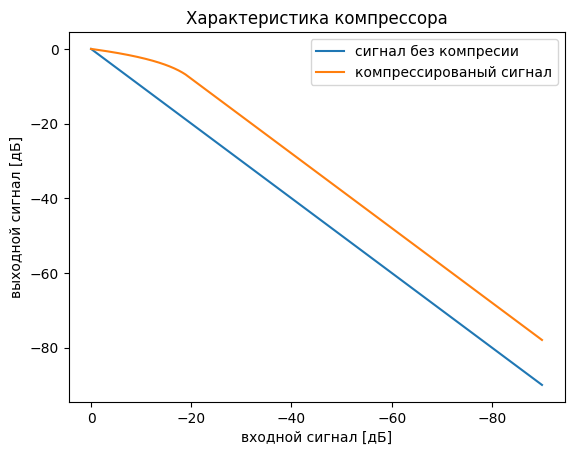

In [17]:
fig, ax = plt.subplots()

plt.plot(test_sig_db,
         test_sig_db,
         label="сигнал без компресии")

plt.plot(test_sig_db,
         test_compress_sig_db,
         label="компрессированый сигнал")


# plt.xlim(-30,0)
# plt.ylim(-30,0)
plt.gca().invert_xaxis()

plt.title("Характеристика компрессора")
plt.xlabel("входной сигнал [дБ]")
plt.ylabel("выходной сигнал [дБ]")

plt.legend()
plt.show()

Обработаем компрессором входной сигнал

In [18]:
compress_sig = vectorize(compessor)(sig_norm, A)

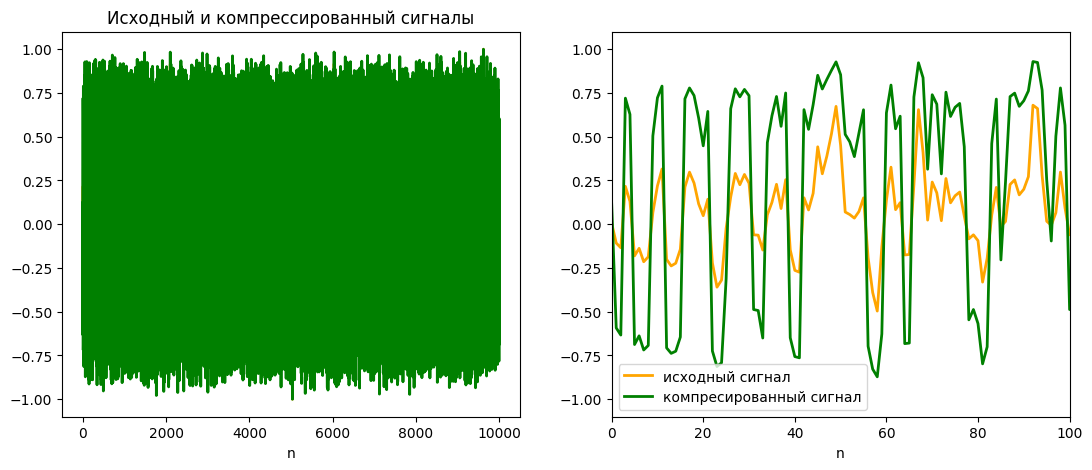

In [19]:
# plot
fig, ax = plt.subplots(1, 2)


ax[0].plot(n, sig_norm,
        linewidth=2.0,
        label='исходный сигнал',
        color="orange")
ax[0].plot(n, compress_sig,
        linewidth=2.0,
        label='компресированный сигнал',
        color="green")
ax[0].set_title('Исходный и компрессированный сигналы')
ax[0].set_xlabel('n')



ax[1].plot(n, sig_norm,
        linewidth=2.0,
        label='исходный сигнал',
        color="orange")
ax[1].plot(n, compress_sig,
        linewidth=2.0,
        label='компресированный сигнал',
        color="green")
ax[1].set_xlabel('n')
ax[1].set_xlim(0,100)


# plt.xlabel("n")
# plt.ylabel("compress_sig")

plt.legend()
fig.set_size_inches(13, 5)
plt.show()

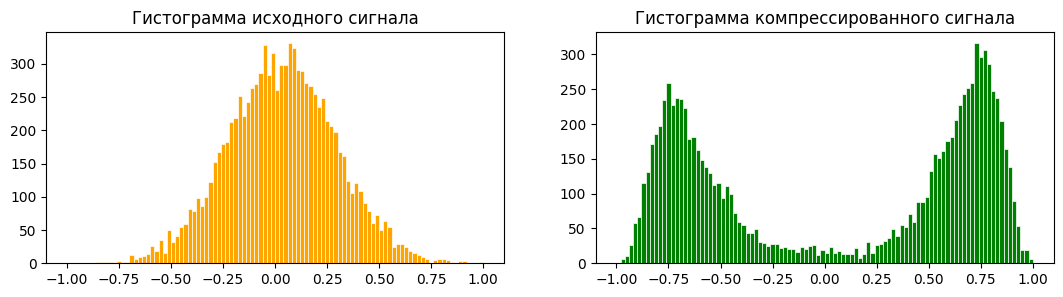

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(sig_norm, bins=int(size/100),
         linewidth=0.5,
         edgecolor="white",
         color="orange")
ax1.set_title('Гистограмма исходного сигнала')

ax2.hist(compress_sig, bins=int(size/100),
         linewidth=0.5,
         edgecolor="white",
         color="green")
ax2.set_title('Гистограмма компрессированного сигнала')

fig.set_size_inches(13, 3)
plt.show()

Таким образом, можно наблюдать характеристику компресора, которая *соответсвует* теоритической, представленной в [статье википедии](https://en.m.wikipedia.org/wiki/A-law_algorithm).
  
Также можно наблюдать распределение, полученное после обработки сигнала компрессором.

### Квантование сигнала
Чтобы не нарушать общности, перейдем к реализации блока **квантователя**. Квантователь реализован на идеи вычисления "расстояния" между уровнями квантования и текущим уровнем сигнала. После вычисления метрики, производится поиск ближайщего уровня квантования к текущему отсчету сигнала. Таким образом, получаем значание на выходе квантователя.

In [21]:
def quantizer(signal, N):
  quantized_signal = []
  step = (max(signal) - min(signal))/N
  levels = np.array([step*i for i in range(N + 1)]) + min(signal)
  for countdown in signal:
    distance = np.abs(levels - countdown)
    curent_level = levels[np.argmin(distance)]
    quantized_signal.append(curent_level)
  return quantized_signal, levels


 Теперь проведем квантование полученного комперсиированного сигнала

In [22]:
quanted_sig, levels = quantizer(compress_sig, b)
# print(quanted_sig)

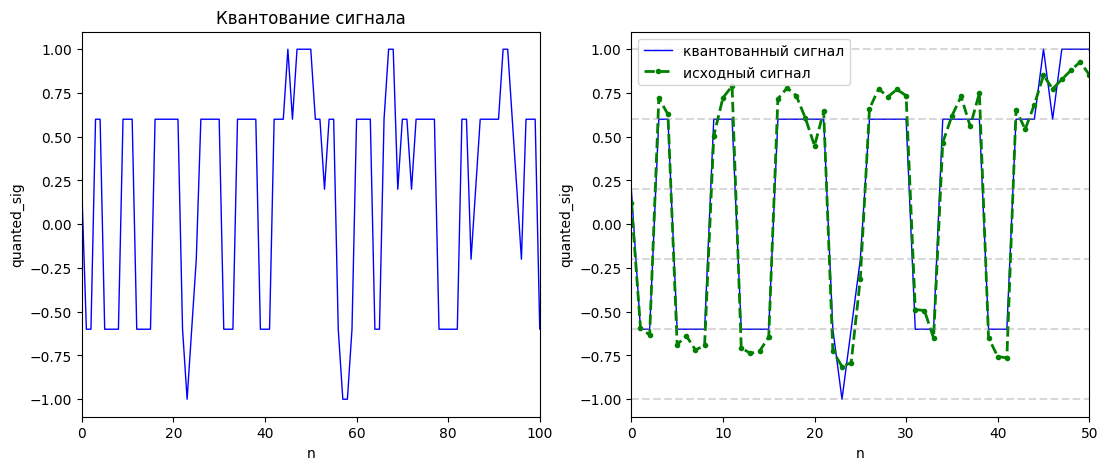

In [23]:
# plot
fig, ax = plt.subplots(1,2)

#======================================

ax[0].plot(n, quanted_sig,
        linewidth=1.0,
        label="квантованный сигнал",
        color = "blue")

ax[0].set_title("Квантование сигнала")
ax[0].set_xlabel("n")
ax[0].set_ylabel("quanted_sig")
ax[0].set_xlim(0,1e2)

fig.set_size_inches(13, 5)
#======================================

ax[1].plot(n, quanted_sig,
        linewidth=1.0,
        label="квантованный сигнал",
        color = "blue")

ax[1].set_xlabel("n")
ax[1].set_ylabel("quanted_sig")

ax[1].plot(n, compress_sig,
        linewidth=2.0,
        linestyle='--',
        marker='.',
        label="исходный сигнал",
        alpha=1,
        color="green")

for i_level in levels:
  ax[1].axhline(y=i_level,
              color='gray',
              linestyle='--',
              alpha = 0.3)

ax[1].legend()
ax[1].set_xlim(0,0.5e2)

#======================================

plt.show()

Здесь можно наблюдать, что квантователь *выполянет свою функцию*.

### Экспандирование сигнала
Теперь проведем операцию обратную компрессированию - **экспандирование**. Преобразование будем проводить, что по следующей формуле

\begin{equation}
    x = sgn(y)
    \begin{cases}
      \frac{|y|(1 + ln(A))}{A}, |y| < \frac{1}{1 + ln(A)}\\
      \frac{e^{-1 + |y|(1 + ln(A))}}{A}, \frac{1}{1 + ln(A)} \leq |y| \leq 1\\
    \end{cases}\,.
\end{equation}


In [24]:
def expander(y, A):
  if abs(y) < 1/(1 + log(A)):
    return (abs(y)*(1 + log(A)))/A*copysign(1,y)
  elif 1/(1+log(A)) <= abs(y) or abs(y) <= 1:
    return exp(-1 + abs(y)*(1 + log(A)))/A*copysign(1,y)

!!Для **проверки** работы алгоритма, проведем преобразование **компресированного** сигнала

In [25]:
expand_sig_test = vectorize(expander)(compress_sig, A)

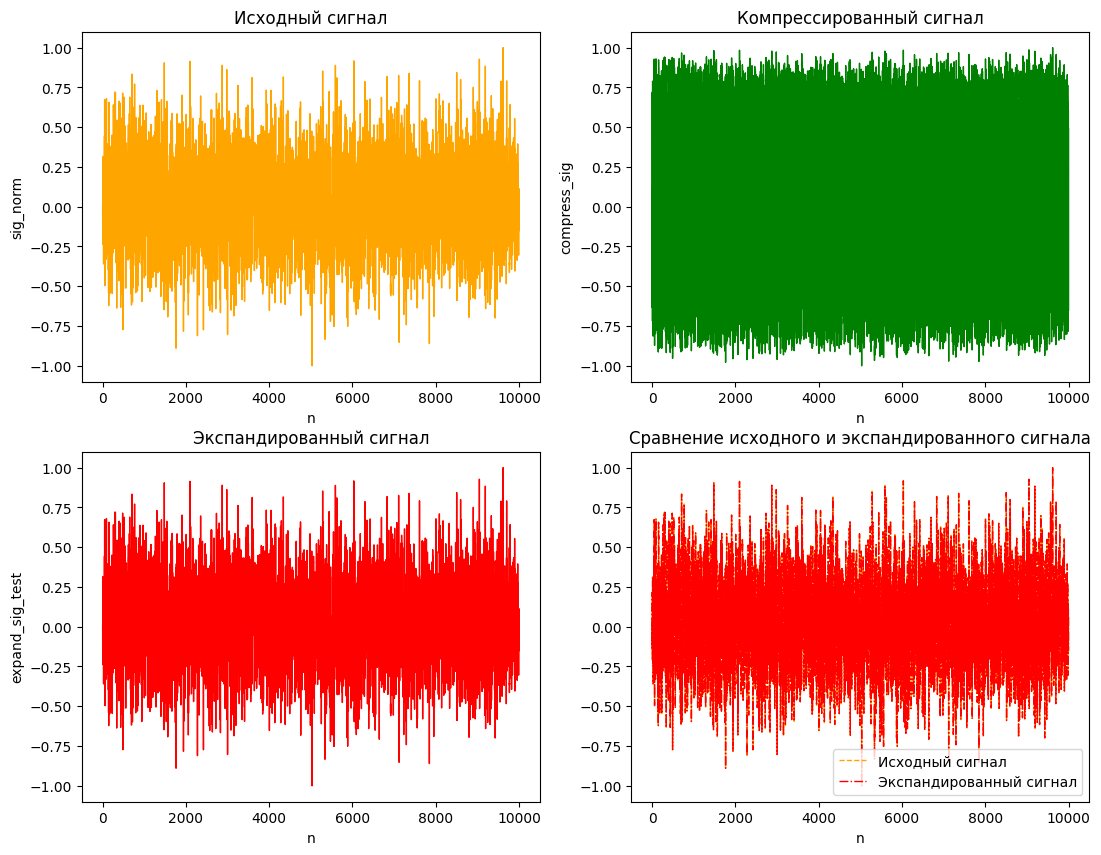

In [26]:

fig, axs = plt.subplots(2,2)

axs[0,0].plot(sig_norm,
         linewidth=1,
         color="orange")
axs[0,0].set_title('Исходный сигнал')
axs[0,0].set_xlabel("n")
axs[0,0].set_ylabel("sig_norm")

axs[0,1].plot(compress_sig,
         linewidth=1,
         color="green")
axs[0,1].set_title('Компрессированный сигнал')
axs[0,1].set_xlabel("n")
axs[0,1].set_ylabel("compress_sig")



axs[1,0].plot(expand_sig_test,
         linewidth=1,
         color="red")
axs[1,0].set_title('Экспандированный сигнал')
axs[1,0].set_xlabel("n")
axs[1,0].set_ylabel("expand_sig_test")


axs[1,1].plot(sig_norm,
         linewidth=1,
         color="orange",
        #  alpha=0.5,
         linestyle='--',
         label='Исходный сигнал')

axs[1,1].plot(expand_sig_test,
         linewidth=1,
         color="red",
        #  alpha=1.0,
         linestyle='-.',
         label='Экспандированный сигнал')
axs[1,1].legend()
axs[1,1].set_title('Сравнение исходного и экспандированного сигнала')
axs[1,1].set_xlabel("n")



fig.set_size_inches(13, 10)
plt.show()

Таким образом, можно судить, что операция компрессирование и экспандирование производят взаимо обраные операции, а значит алгоритмы работают *верно*.

## Эксперименты с параметром компандирования

### Вычисление SQNR

В общем виде схема обработки сигнал будет выглядеть следующим образом

![Схема устройства](https://github.com/AlfaIV/RFinfSystem/blob/hm1/png/Схема%20ДЗ1%20РСПИ.drawio.png?raw=true)

Сформируем требуемую схему обработки

In [27]:
def Process_Circuit(input_sig, A = A):
  compress_sig = vectorize(compessor)(input_sig, A)
  quanted_sig, levels = quantizer(compress_sig, b)
  expand_sig = vectorize(expander)(quanted_sig, A)
  return expand_sig

In [28]:
expand_sig = Process_Circuit(sig_norm)

Теперь найдем отношение сигнал шум.

In [29]:
SQNR = lambda sig_norm, expand_sig: 10*log10(sum(sig_norm**2)/sum((sig_norm - expand_sig)**2))

In [30]:
f"Отношение сигнал/шум с установленным параметром А = 87.56 равен SQNR = {SQNR(sig_norm, expand_sig)}"

'Отношение сигнал/шум с установленным параметром А = 87.56 равен SQNR = 0.20596802055662183'

### Зависимость SQNR от А

А теперь постоим зависимость SQNR от параметра А

In [31]:
A_array = linspace(30,100,500)

In [32]:
SQNR_array = [SQNR(sig_norm, Process_Circuit(sig_norm, A)) for A in A_array]

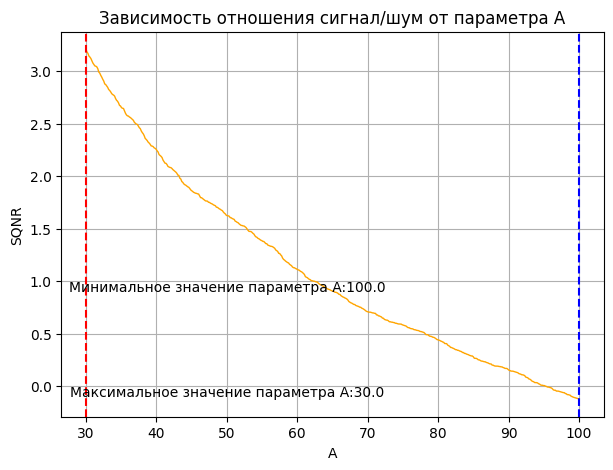

In [33]:
maxA = A_array[np.argmax(SQNR_array)]
minA = A_array[np.argmin(SQNR_array)]

fig, ax = plt.subplots()
ax.plot(A_array,
        SQNR_array,
        linewidth=1,
        color="orange")

ax.set_xlabel('A')
ax.set_ylabel('SQNR')
ax.set_title('Зависимость отношения сигнал/шум от параметра А')

plt.axvline(maxA,
            color = "red",
            linestyle="--")

plt.axvline(minA,
            color = "blue",
            linestyle="--")


ax.text(max(A_array)/2,min(SQNR_array), f'Максимальное значение параметра A:{maxA}', ha='center', va='bottom')
ax.text(max(A_array)/2,min(SQNR_array) + 1, f'Минимальное значение параметра A:{minA}', ha='center', va='bottom')

plt.grid(True)
fig.set_size_inches(7, 5)
plt.show()

### Сравнение оптимального и неоптимального значения SQNR

Тепрь изобразим на одном графике осциллограммы сигналов с и без компандирования при оптимальном(максимальное SQNR) и неоптимальном(минимальном SQNR) значении параметра сжатия.

In [34]:
expand_sig_opt = Process_Circuit(sig_norm, maxA)
expand_sig_bad = Process_Circuit(sig_norm, minA)

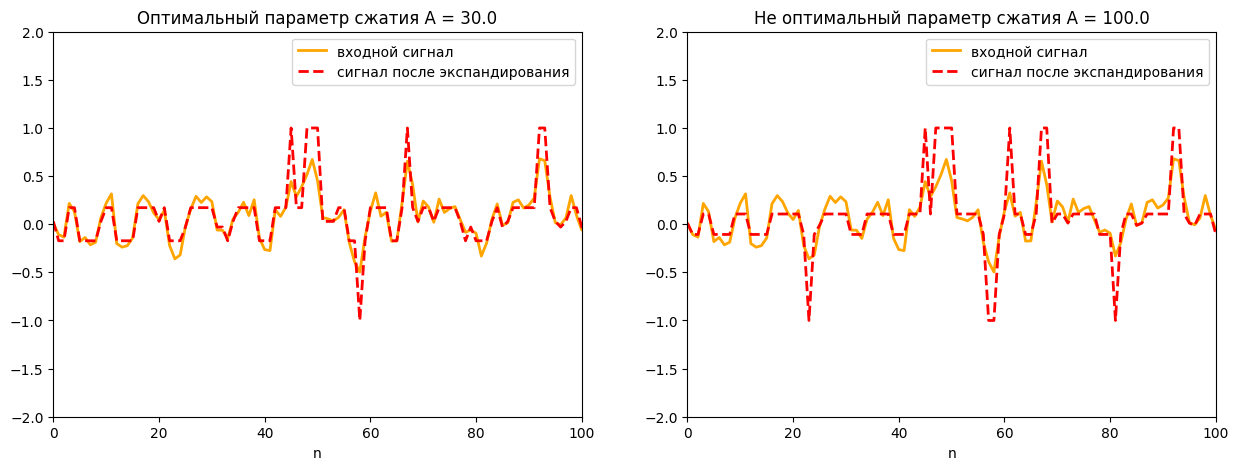

In [35]:
# plot
fig, ax = plt.subplots(1,2)

#======================================

ax[0].plot(n, sig_norm,
        linewidth=2.0,
        label="входной сигнал",
        color = "orange")

ax[0].plot(n, expand_sig_opt,
        linewidth=2.0,
        label="сигнал после экспандирования",
        linestyle='--',
        color = "red")

ax[0].set_title(f"Оптимальный параметр сжатия А = {maxA}")
ax[0].set_xlabel("n")
ax[0].legend()
ax[0].set_xlim(0,100)
ax[0].set_ylim(-2,2)

#======================================

ax[1].plot(n, sig_norm,
        linewidth=2.0,
        label="входной сигнал",
        color = "orange")


ax[1].plot(n, expand_sig_bad,
        linewidth=2.0,
        linestyle='--',
        # marker='.',
        # label="исходный сигнал",
        # alpha=1,
        label="сигнал после экспандирования",
        color="red")

ax[1].set_title(f"Не оптимальный параметр сжатия А = {minA}")
ax[1].legend()
ax[1].set_xlabel("n")
ax[1].set_xlim(0,100)
ax[1].set_ylim(-2,2)

#======================================

fig.set_size_inches(15, 5)
plt.show()

### Вывод

  При использовании неоптимального параметра компандирования сигнала происходят следующие изменения:

1. **Искажение сигнала**: Неоптимальный параметр компандирования может привести к искажению сигнала. Компандирование используется для увеличения динамического диапазона сигнала, но неправильно выбранный параметр может привести к искажениям и потере качества сигнала.

2. **Потеря деталей**: Неоптимальный параметр компандирования может привести к потере деталей в сигнале. Если параметр выбран слишком низким, то могут быть потеряны низкоуровневые сигналы и детали, что может привести к ухудшению качества воспроизведения.

3. **Увеличение шума**: Неоптимальный параметр компандирования может привести к увеличению уровня шума в сигнале. Если параметр выбран слишком высоким, то шумы и помехи могут быть усилены, что может негативно сказаться на качестве сигнала.

4. **Изменение динамического диапазона**: Неоптимальный параметр компандирования может изменить динамический диапазон сигнала. Если параметр выбран неправильно, то могут быть потеряны или искажены сигналы с низким или высоким уровнем амплитуды.

Важно выбирать оптимальные параметры компандирования сигнала, чтобы достичь наилучшего качества и минимизировать искажения и потери информации.